# Initial Analysis

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

## New Approach to Efficiently Scrape Data

In order to have more data to work with and to acquire it efficiently, we will now automatically scrape the appropriate 3 tables from [basketball-reference.com](https://www.basketball-reference.com/). Appropriate columns will be dropped. A [dataset](https://www.kaggle.com/boonpalipatana/nba-season-records-from-every-year) containing all the team playoff finishes is used to automically label each of teams. Assigning teams with a top 5 MVP candidate was not feasible so through this new approach that feature will not exist. Also because the data for team seeds does not have a seeding based on conference for all years going back to 1980, the 'Seed' column does not exist.

In [10]:
def getData(year, records):
        y = str(year)
        url='https://www.basketball-reference.com/leagues/NBA_'+y+'.html'
        response=requests.get(url).content
        soup = bs(response)
        basic = soup.find('div',{'id':'all_team-stats-per_game'}).contents[5]
        df = pd.read_html(basic)[0]
        opp = soup.find('div',{'id':'all_opponent-stats-per_game'}).contents[5]
        df2 = pd.read_html(opp)[0]
        misc = soup.find('div',{'id':'all_misc_stats'}).contents[5]
        df3 = pd.read_html(misc)[0]
        df3.columns = df3.columns.droplevel()
        df3 = df3.drop(["Rk", "W", "L", 'PW', 'PL', 'MOV', 'ORB%', 'DRB%', 'FT/FGA', 'Arena', 'Attend.', 'FTr'],axis = 1)
        df3.columns = ['Team', 'Age', 'SOS', 'SRS', 'ORtg', 'DRtg' , 'NRtg', 'Pace', '3PAr' ,'TS%', 'eFG%', 'TOV%', 'op_eFG%', 'op_TOV%', 'Attend./G']
        df3 = df3.drop(["op_TOV%"], axis =1)
        basic = clean(df, False)
        opp = clean(df2, True)
        df3['Team'] = df3['Team'].str.replace(r'*', '')
        adv = df3.set_index("Team")
        df = pd.concat([basic, opp, adv], axis=1, sort = True)
        
        results = {'Lost E. Conf. Finals' :'Conference Finals', 'Lost W. Conf. Finals' : 
          'Conference Finals', 'Lost E. Conf. 1st Rnd.' : '1st Round', 'Lost E. Conf. Semis' : '2nd Round', 
           'Lost W. Conf. Semis' : '2nd Round', 'Lost W. Conf. 1st Rnd.' : '1st Round', 'Lost Finals' : 'Finals',
           'Won Finals': 'Champion', 'DNQ' : 'DNQ'}
        records = records[(records["Season"] == y)].set_index("Team")
        for index, rows in df.iterrows():
            for index2, rows2 in records.iterrows():
                if (index == index2):
                    key = rows2["Playoffs"]
                    rows["Playoffs"] = results.get(key)
                    df.loc[index, "Playoffs"] = rows["Playoffs"]
#         df["Seed"] = 0
#         df["Playoffs_i"] = 0
#         df['Star_Power'] = 0
        df['Year'] = year
        df.rename(columns = {'op_2P.1' : 'op_2P%', 'op_3P.1': 'op_3P%'}, inplace = True)
        df.at["League Average","Playoffs"] = 'DNQ'
        df.at["League Average","NRtg"] = 0
        df.drop(['Attend./G'], axis = 1, inplace = True)
        return df

In [11]:
def clean(df, opp):
    if (opp):
        df.drop(["Rk","G", "MP"], axis = 1, inplace = True)
        df.columns = ['op_' + str(col) for col in df.columns]
        df = df.rename(columns = {'op_Team' : 'Team'})
        df['Team'] = df['Team'].str.replace(r'*', '')
        df = df.set_index("Team")
    else:  
        df['Team'] = df['Team'].str.replace(r'*', '')
        df.drop(["Rk","G", "MP"], axis = 1, inplace = True)
        df = df.set_index("Team")
    return df

In [12]:
records = pd.read_csv("data/Team_Records.csv")
records["Playoffs"] = records["Playoffs"].fillna("DNQ")
def apply(s):
    s = s.split('-')[0]
    r = int(s) + 1
    return str(r)
records["Season"] = records["Season"].apply(apply)
records['Team'] = records['Team'].str.replace(r'*', '')

### Team Stats Correlation Heat Map (All Teams)

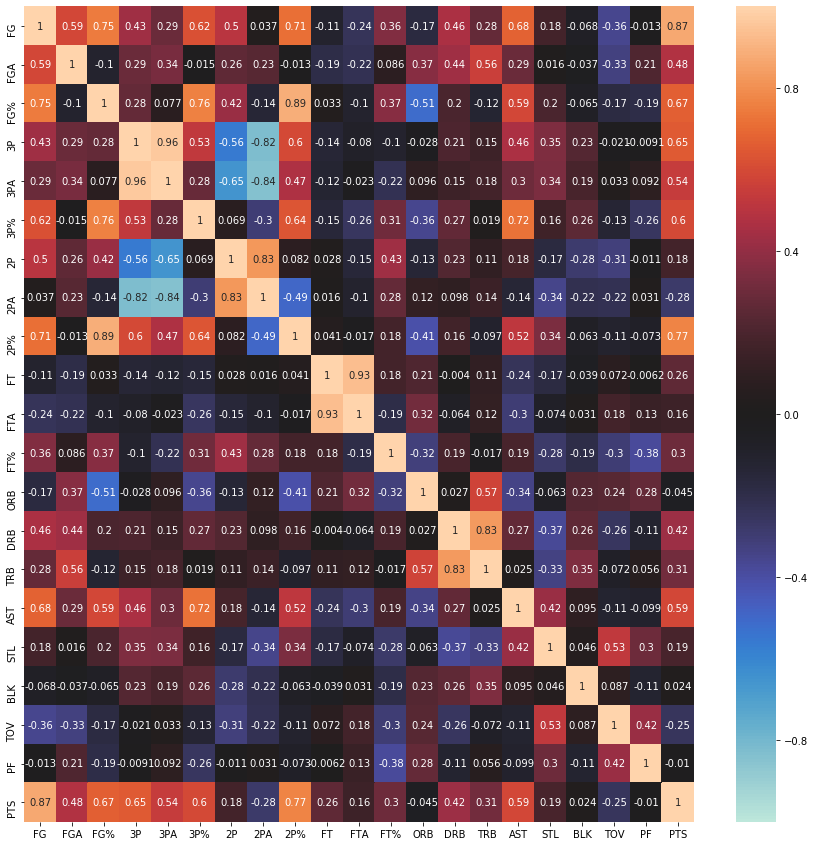

In [12]:
cols2 = [c for c in getData(2015,records).columns[:22] if 'op_' not in c]
df2 = getData(2015,records)[cols2]
plt.figure(figsize=(15, 15))
sns.heatmap(df2.corr(), annot = True, vmin=-1, vmax=1, center= 0)

### Opponent Stats Correlation Heat Map (All Teams)

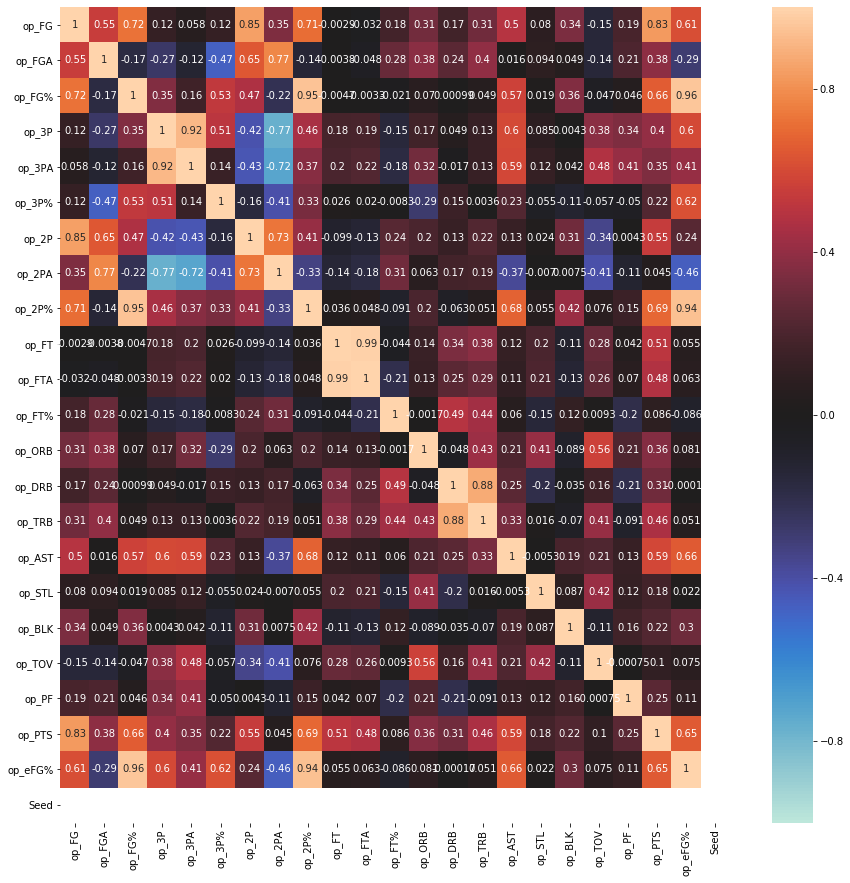

In [68]:
cols = [c for c in getData(2015, records).columns if ('op_' in c or 'Seed' in c)]
df = getData(2015, records)[cols]
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0)

### Team Stats Correlation Heat Map (Top 4 Teams From Each Conference)

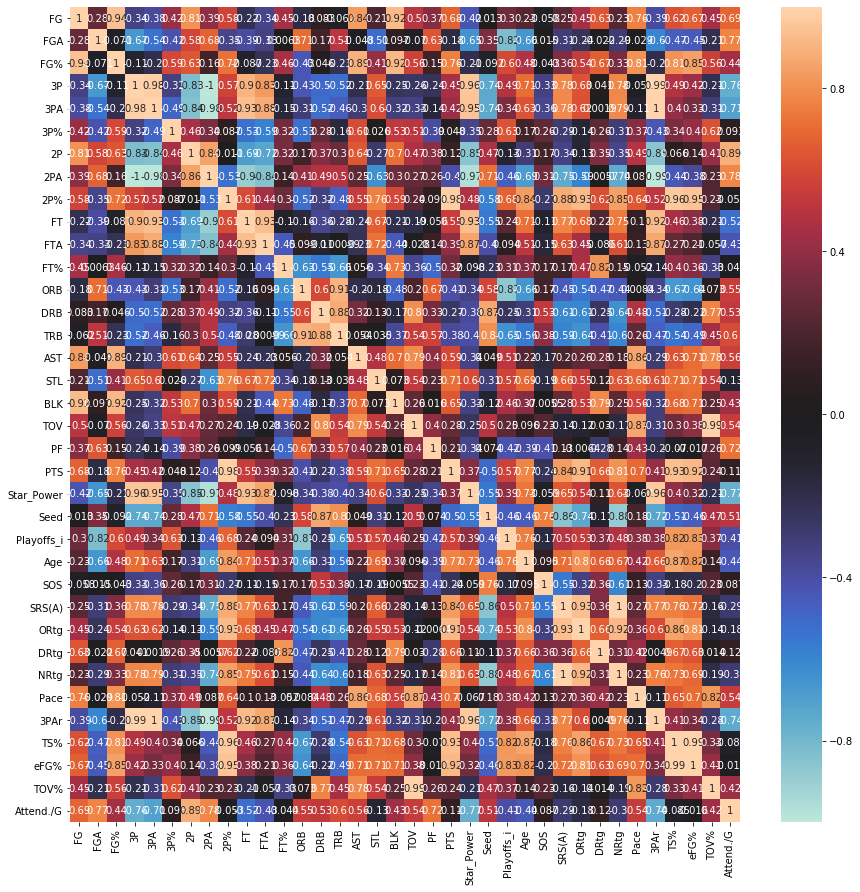

In [41]:
playoff_teams = s2018[(s2018['Seed'] < 4)]
cols3 = [c for c in playoff_teams.columns if 'op_' not in c]
df3 = playoff_teams[cols3]
plt.figure(figsize=(15, 15))
sns.heatmap(df3.corr(), annot = True, vmin=-1, vmax=1, center= 0)

### Team Stats Correlation Heat Map (Bottom 4 Teams From Each Conference)

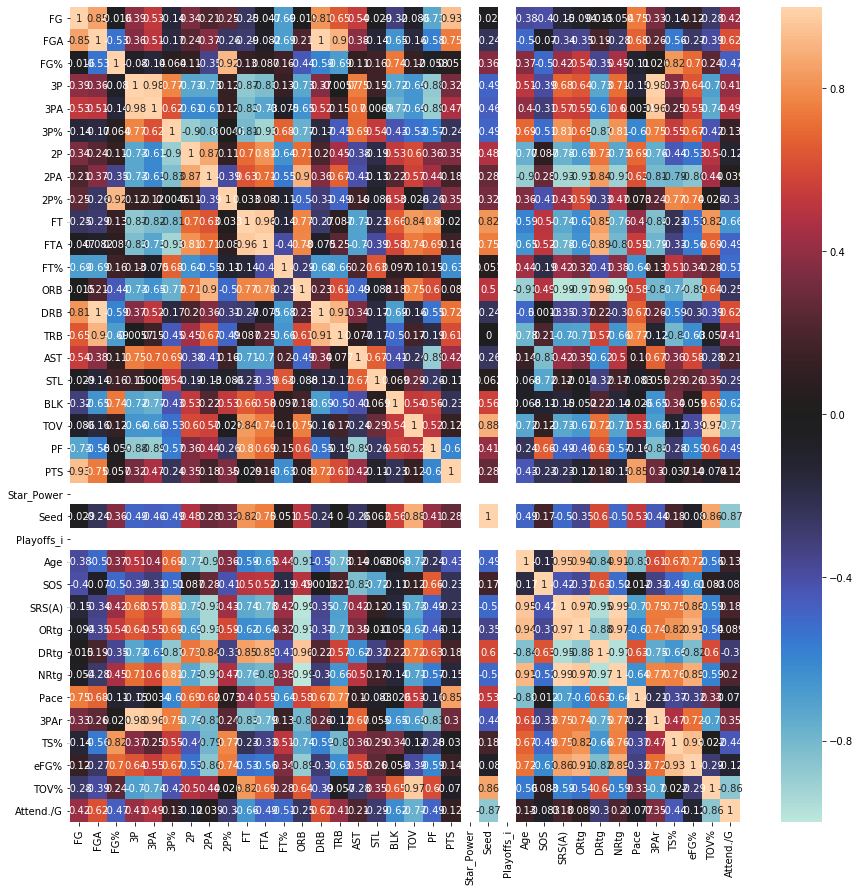

In [42]:
non_playoff_teams = s2018[(s2018['Seed'] > 12)]
cols4 = [c for c in playoff_teams.columns if 'op_' not in c]
df4 = non_playoff_teams[cols3]
plt.figure(figsize=(15, 15))
sns.heatmap(df4.corr(), annot = True, vmin=-1, vmax=1, center= 0)

In [28]:
s2018 = pd.read_excel("data/s2017-18.xlsx")
s2018.rename(columns = {"Unnamed: 0" : "Team"}, inplace = True)
s2018 = s2018.set_index("Team")

In [29]:
s2018.columns[:36]

Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'op_FG', 'op_FGA', 'op_FG%', 'op_3P', 'op_3PA', 'op_3P%', 'op_2P',
       'op_2PA', 'op_2P%', 'op_FT', 'op_ORB', 'op_AST', 'op_TOV', 'op_PTS',
       'Star_Power'],
      dtype='object')

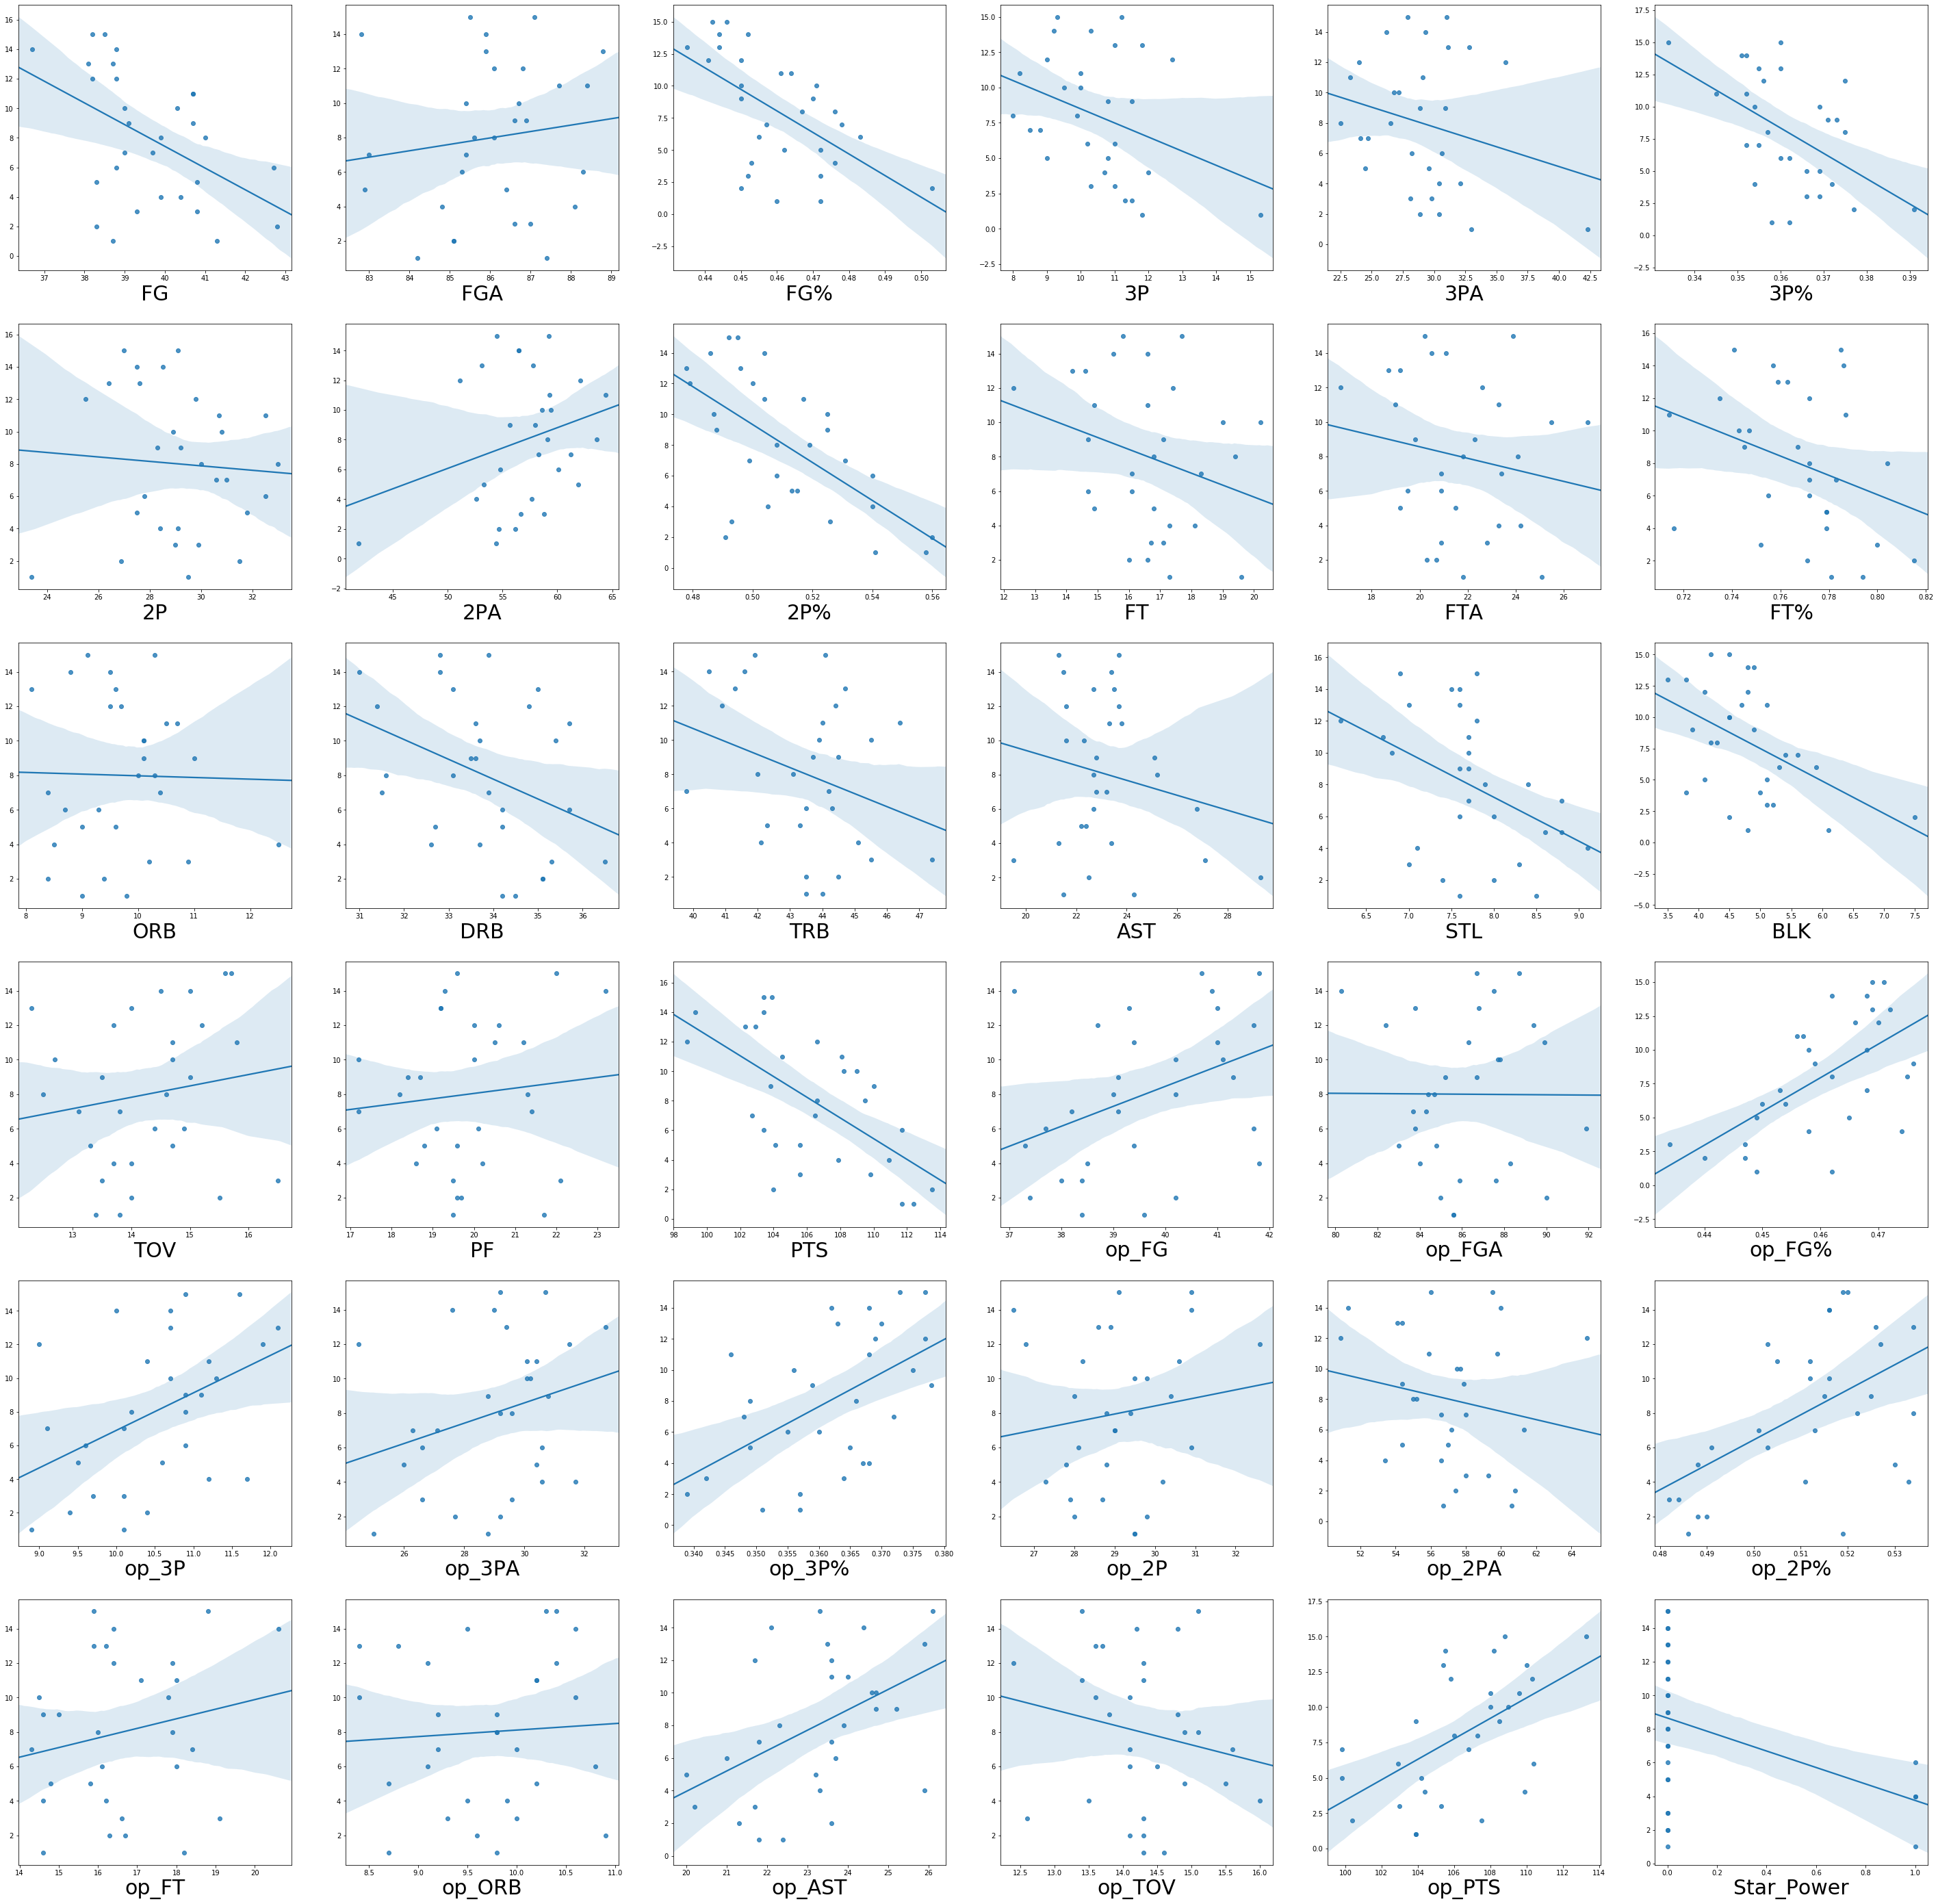

In [30]:
i = 0
fig = plt.figure(figsize=(50, 50))
for s in s2018.columns[:36]:
    ax = fig.add_subplot(6,6, i+1)
    sns.regplot(s, "Seed", data = s2018, ax = ax)
    plt.xlabel(s, fontsize=30)
    plt.ylabel("")
    i = i + 1
# fig.text(0.09, 0.55, 'Seed', va='center', rotation='vertical', fontsize = 75)
plt.show()


# Principal Component Analysis

In [39]:
%matplotlib notebook
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Setup

In [36]:
data = pd.DataFrame()
# data = getData(1980, records)
for i in range(1980,2018):
    data = pd.concat([data, getData(i, records)])
# data = pd.concat([getData(2005, records), getData(2006, records),getData(2006, records), getData(2007, records), 
#                  getData(2008, records), getData(2009, records), getData(2010, records)])
# data = pd.concat([getData(2017, records), getData(2016, records)])
features = data.drop(["Playoffs", "Year"], axis = 1).values
labels = data.loc[:,['Playoffs']].values
target_labels = ['DNQ', '1st Round', '2nd Round', 'Conference Finals', 'Finals', 'Champion']
centroid_labels = ['DNQ_cluster', '1st Round_cluster', '2nd Round_cluster', 'Conference Finals_cluster', 'Finals_cluster', 'Champion_cluster' ]
target_labels2020 = ['TBD']
target_df = data[["Playoffs"]].reset_index().drop(["index"], axis = 1)
features = StandardScaler().fit_transform(features)

## Principal Component Analysis (2D)

In [37]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features)
df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([df, target_df], axis = 1)
finalDf['Year'] = data['Year'].to_numpy()
twoD = finalDf
finalDf.head(10)

,pc1,pc2,Playoffs,Year
0,6.946707,-0.676230,2nd Round,1980
1,6.386788,3.648859,Conference Finals,1980
2,8.098726,-0.809502,DNQ,1980
3,9.144875,-0.724433,DNQ,1980
4,7.761272,-2.089637,DNQ,1980
5,9.875502,-3.399512,DNQ,1980
6,5.890975,-2.337123,DNQ,1980
7,8.352425,-0.071541,2nd Round,1980
8,9.457302,-1.027742,DNQ,1980
9,7.144646,-0.122234,1st Round,1980


<IPython.core.display.Javascript object>


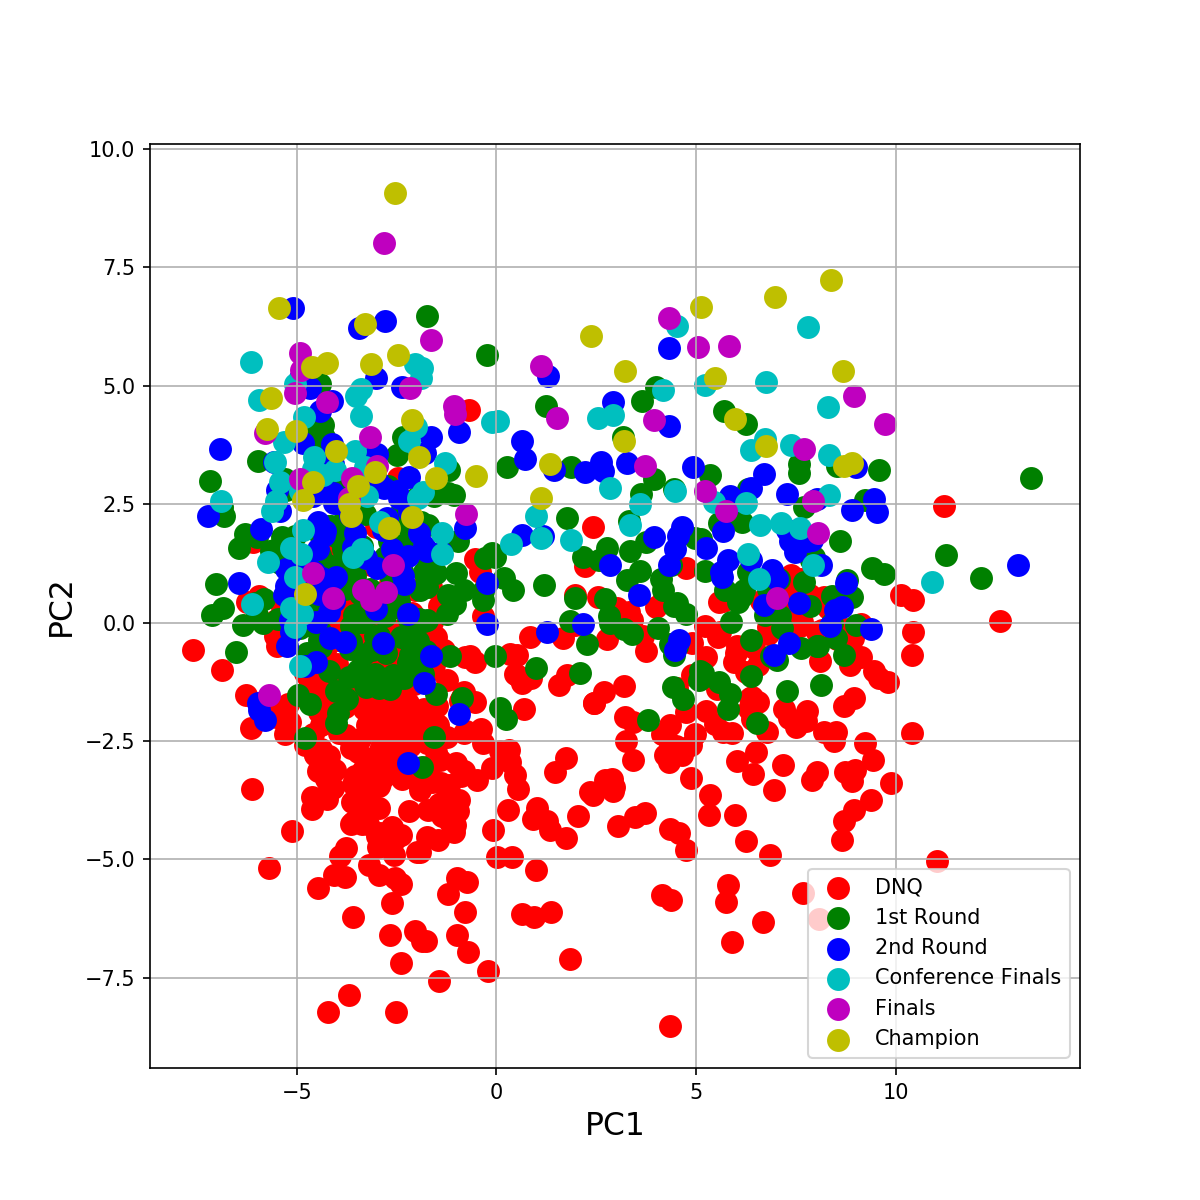

In [42]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(target_labels,colors):
    indicesToKeep = finalDf['Playoffs'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'] ,finalDf.loc[indicesToKeep, 'pc2'], c = color ,s = 100)
ax.legend(target_labels)
# ax.set_xlim([-10,13])
# ax.set_ylim([-8,8])
# for i, txt in enumerate(data.index):
#     plt.annotate(txt.split()[-1], (finalDf.iloc[:,0][i], finalDf.iloc[:,1][i]))
ax.grid()

In [43]:
print("PC1 contains", pca.explained_variance_ratio_[0] * 100, "% of the variance")
print("PC2 contains", pca.explained_variance_ratio_[1] * 100, "% of the variance")

PC1 contains 40.87423714383439 % of the variance
PC2 contains 14.35299145467899 % of the variance


In [45]:
weights = pd.DataFrame(pca.components_,columns=data.drop(["Playoffs", "Year"], axis = 1).columns,index = ['PC1','PC2'])
w = weights.values
w.sort(axis=1)
w = w[:, ::-1]
pd.DataFrame(w, weights.index, weights.columns)
weights = weights[weights.columns[::-1]]
weights

,op_eFG%,TOV%,eFG%,TS%,3PAr,Pace,NRtg,DRtg,ORtg,SRS,...,FT,2P%,2PA,2P,3P%,3PA,3P,FG%,FGA,FG
PC1,0.203221,0.202822,0.199716,0.199265,0.187700,0.182345,0.181857,0.175428,0.170085,0.168748,...,-0.043352,-0.052762,-0.071745,-0.150512,-0.155296,-0.175373,-0.175873,-0.180611,-0.182030,-0.182256
PC2,0.328632,0.326960,0.304544,0.300967,0.297363,0.282825,0.233634,0.182310,0.173148,0.163957,...,-0.075792,-0.091935,-0.100541,-0.106987,-0.108274,-0.113417,-0.128117,-0.132004,-0.155347,-0.183358


## Principal Component Analysis (3D)

In [46]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(features)
df = pd.DataFrame(data = principalComponents , columns = ['pc1', 'pc2', 'pc3'])
finalDf = pd.concat([df, target_df], axis = 1)
# finalDf['Year'] = data['Year']
finalDf['Year'] = data['Year'].to_numpy()
finalDf.head(10)

,pc1,pc2,pc3,Playoffs,Year
0,6.946707,-0.676230,5.149578,2nd Round,1980
1,6.386788,3.648859,1.527074,Conference Finals,1980
2,8.098726,-0.809502,0.641769,DNQ,1980
3,9.144875,-0.724433,-1.997261,DNQ,1980
4,7.761272,-2.089637,-0.714935,DNQ,1980
5,9.875502,-3.399512,-1.328816,DNQ,1980
6,5.890975,-2.337123,0.120275,DNQ,1980
7,8.352425,-0.071542,-0.372000,2nd Round,1980
8,9.457302,-1.027742,-0.215180,DNQ,1980
9,7.144646,-0.122234,2.091426,1st Round,1980


<IPython.core.display.Javascript object>


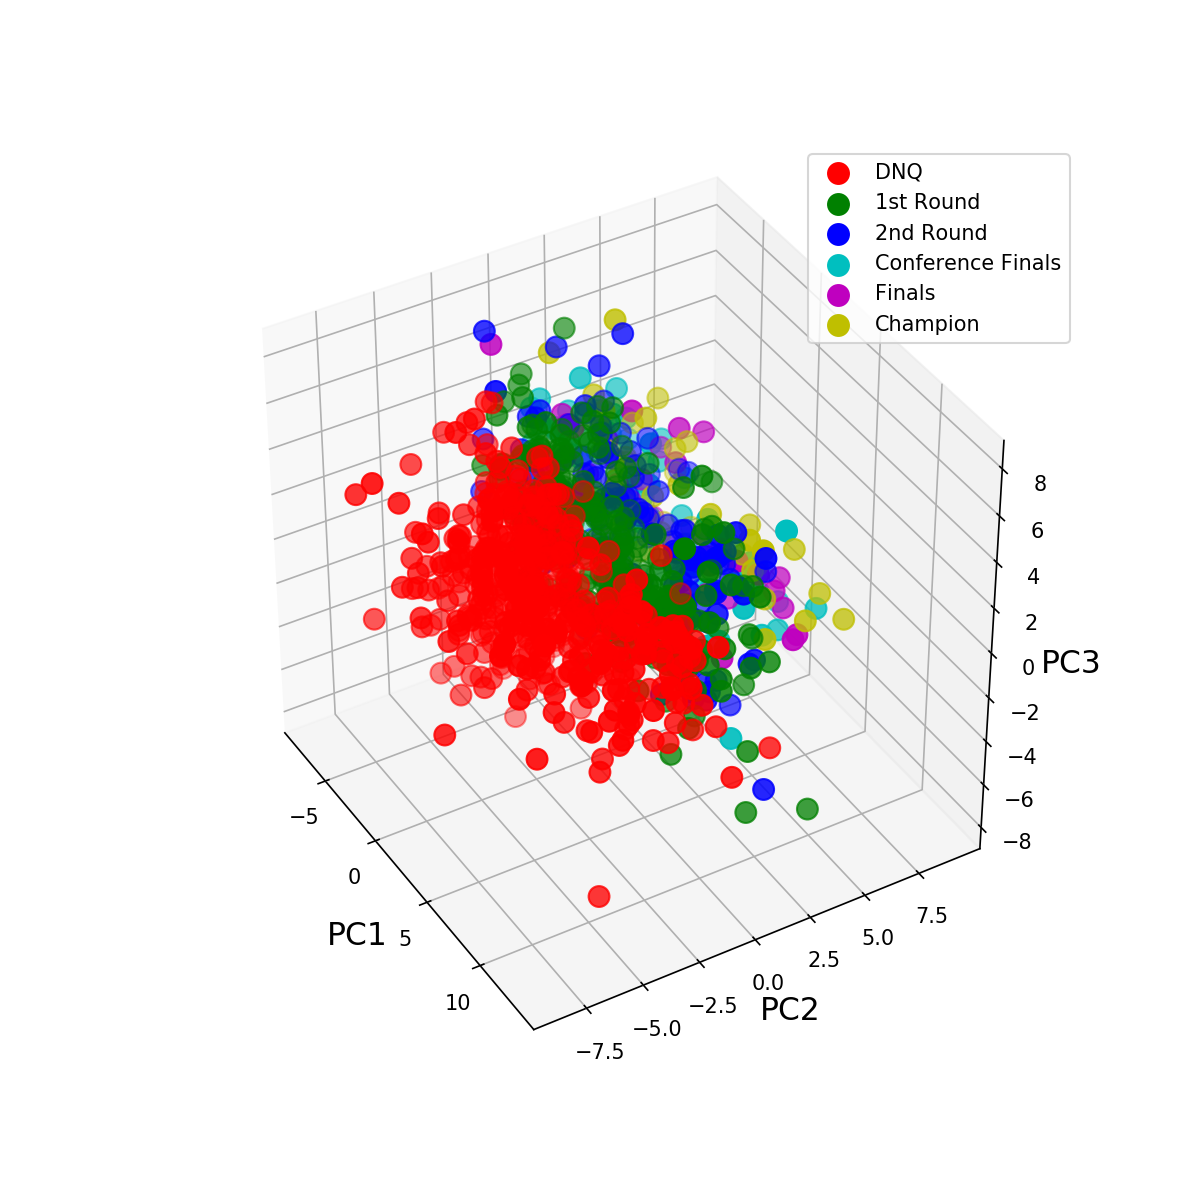

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection = '3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(target_labels,colors):
    indicesToKeep = finalDf['Playoffs'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'] ,finalDf.loc[indicesToKeep, 'pc2'],finalDf.loc[indicesToKeep, 'pc3']  , c = color ,s = 100)
ax.legend(target_labels)
ax.grid()

In [1470]:
print("PC1 contains", pca.explained_variance_ratio_[0] * 100, "% of the variance")
print("PC2 contains", pca.explained_variance_ratio_[1] * 100, "% of the variance")
print("PC3 contains", pca.explained_variance_ratio_[2] * 100, "% of the variance")

PC1 contains 40.87423714383433 % of the variance
PC2 contains 14.352991454679016 % of the variance
PC3 contains 11.358842297823687 % of the variance


In [48]:
weights = pd.DataFrame(pca.components_,columns=data.drop(["Playoffs", "Year"], axis = 1).columns,index = ['PC1','PC2', 'PC3'])
w = weights.values
w.sort(axis=1)
w = w[:, ::-1]
pd.DataFrame(w, weights.index, weights.columns)
weights = weights[weights.columns[::-1]]
weights

,op_eFG%,TOV%,eFG%,TS%,3PAr,Pace,NRtg,DRtg,ORtg,SRS,...,FT,2P%,2PA,2P,3P%,3PA,3P,FG%,FGA,FG
PC1,0.203221,0.202822,0.199716,0.199265,0.187700,0.182345,0.181857,0.175428,0.170085,0.168748,...,-0.043352,-0.052762,-0.071745,-0.150512,-0.155296,-0.175373,-0.175873,-0.180611,-0.182030,-0.182256
PC2,0.328632,0.326960,0.304544,0.300967,0.297363,0.282825,0.233634,0.182310,0.173148,0.163957,...,-0.075792,-0.091935,-0.100541,-0.106987,-0.108274,-0.113417,-0.128117,-0.132004,-0.155347,-0.183358
PC3,0.173627,0.118779,0.118684,0.116080,0.113895,0.105254,0.103996,0.094839,0.093366,0.077570,...,-0.163714,-0.166185,-0.169200,-0.182050,-0.185370,-0.231212,-0.241575,-0.289761,-0.295065,-0.321714


# Model Building

In [122]:
train_data = pd.DataFrame()
for i in range(1980,2018):
    train_data = pd.concat([train_data, getData(i, records)])

## KNN Classifcation Model (Standard data)

In [121]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score

In [168]:
y = train_data['Playoffs'].values
X = train_data.drop(['Playoffs', 'Year'], axis=1).values
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                     weights='uniform')

In [172]:
cv_results = cross_val_score(knn,X,y,cv=5)
print(cv_results)
print("Mean: ", np.mean(cv_results))
# print(knn.score(X_new, new_data['Playoffs']))
# results

[0.48401826 0.56880734 0.61290323 0.57476636 0.56542056]
Mean:  0.5611831491968051


In [171]:
"""
Predicting every year from 1980-2017 on the training data. 
Testing the model's ability to predict SEEN data.

"""
y = train_data['Playoffs'].values
X = train_data.drop(['Playoffs', 'Year'], axis=1).values
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
for i in range(1980,2018):
# y_pred = knn.predict(X)
    new_data = getData(i, records)
# new_data = pd.concat([getData(2010, records), getData(2011, records),getData(2012, records), getData(2013, records), 
# getData(2014, records), getData(2015, records), getData(2016, records), getData(2017, records)])
    X_new = new_data.drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = knn.predict(X_new)
    results = new_data
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", knn.score(X_new, new_data['Playoffs']))



The actual Champion was predicted:  Champion
Year:  1980   0.6086956521739131
The actual Champion was predicted:  Champion
Year:  1981   0.8333333333333334
The actual Champion was predicted:  Champion
Year:  1982   0.7083333333333334
The actual Champion was predicted:  Conference Finals
Year:  1983   0.625
The actual Champion was predicted:  Champion
Year:  1984   0.5416666666666666
The actual Champion was predicted:  Champion
Year:  1985   0.5416666666666666
The actual Champion was predicted:  Champion
Year:  1986   0.625
The actual Champion was predicted:  Conference Finals
Year:  1987   0.6666666666666666
The actual Champion was predicted:  Finals
Year:  1988   0.4583333333333333
The actual Champion was predicted:  Champion
Year:  1989   0.6923076923076923
The actual Champion was predicted:  Champion
Year:  1990   0.6071428571428571
The actual Champion was predicted:  Champion
Year:  1991   0.6785714285714286
The actual Champion was predicted:  Champion
Year:  1992   0.6785714285714

In [104]:
"""
Predicting every year from 1980-2017 where the training data is every year except the one to be predicted. 
Testing the model's ability to predict UNSEEN data.

"""
for i in range (1980, 2018):
    y = train_data[(train_data.Year != i)]['Playoffs'].values
    X = train_data[(train_data.Year != i)].drop(['Playoffs', 'Year'], axis=1).values
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X, y)
    X_new = train_data[(train_data.Year == i)].drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = knn.predict(X_new)
    results = train_data[(train_data.Year == i)]
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", knn.score(X_new,train_data[(train_data.Year == i)]['Playoffs']))

The actual Champion was predicted:  Champion
Year:  1980   0.43478260869565216
The actual Champion was predicted:  Conference Finals
Year:  1981   0.5
The actual Champion was predicted:  Finals
Year:  1982   0.5833333333333334
The actual Champion was predicted:  Conference Finals
Year:  1983   0.5
The actual Champion was predicted:  Champion
Year:  1984   0.5
The actual Champion was predicted:  Conference Finals
Year:  1985   0.4583333333333333
The actual Champion was predicted:  Conference Finals
Year:  1986   0.4166666666666667
The actual Champion was predicted:  Conference Finals
Year:  1987   0.5416666666666666
The actual Champion was predicted:  Finals
Year:  1988   0.4583333333333333
The actual Champion was predicted:  1st Round
Year:  1989   0.46153846153846156
The actual Champion was predicted:  1st Round
Year:  1990   0.39285714285714285
The actual Champion was predicted:  Champion
Year:  1991   0.6428571428571429
The actual Champion was predicted:  Champion
Year:  1992   0.60

### Results, Cross Validation

## Random Forest Regression

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
y = data['Playoffs'].values
X = data.drop(['Playoffs', 'Year'], axis=1).values
X_new = data[(data.Year == 2015)].drop(['Playoffs', 'Year'], axis = 1).values
reg_rf = RandomForestClassifier()
reg_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Results, Cross Validation

In [79]:
cv_results = cross_val_score(reg_rf,X,y,cv=5)
print(cv_results)
# print(reg_rf.score(X_new, new_data['Playoffs']))
np.argmax(reg_rf.feature_importances_)
print("Most Importance Feature:", data.columns[44])
# new_data['RF_pred'] = y_pred
print("Mean: ", np.mean(cv_results))
# new_data

[0.52968037 0.6146789  0.64516129 0.6728972  0.59813084]
Most Importance Feature: SRS
Mean:  0.6121097184170261


In [105]:
"""
Predicting every year from 1980-2017 on the training data. 
Testing the model's ability to predict SEEN data.

"""
y = train_data['Playoffs'].values
X = train_data.drop(['Playoffs', 'Year'], axis=1).values
reg_rf = RandomForestClassifier()
reg_rf.fit(X, y)
for i in range(1980,2018):
    new_data = getData(i, records)
    X_new = new_data.drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = reg_rf.predict(X_new)
    results = new_data
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", reg_rf.score(X_new, new_data['Playoffs']))

The actual Champion was predicted:  Champion
Year:  1980   1.0
The actual Champion was predicted:  Champion
Year:  1981   1.0
The actual Champion was predicted:  Champion
Year:  1982   1.0
The actual Champion was predicted:  Champion
Year:  1983   0.9583333333333334
The actual Champion was predicted:  Champion
Year:  1984   1.0
The actual Champion was predicted:  Champion
Year:  1985   1.0
The actual Champion was predicted:  Champion
Year:  1986   1.0
The actual Champion was predicted:  Champion
Year:  1987   1.0
The actual Champion was predicted:  Champion
Year:  1988   1.0
The actual Champion was predicted:  Champion
Year:  1989   1.0
The actual Champion was predicted:  Champion
Year:  1990   1.0
The actual Champion was predicted:  Champion
Year:  1991   1.0
The actual Champion was predicted:  Champion
Year:  1992   1.0
The actual Champion was predicted:  Champion
Year:  1993   1.0
The actual Champion was predicted:  Champion
Year:  1994   0.9642857142857143
The actual Champion was p

In [106]:
"""
Predicting every year from 1980-2017 where the training data is every year except the one to be predicted. 
Testing the model's ability to predict unseen data.

"""
import warnings
warnings.filterwarnings('ignore')
for i in range (1980, 2018):
    y = train_data[(train_data.Year != i)]['Playoffs'].values
    X = train_data[(train_data.Year != i)].drop(['Playoffs', 'Year'], axis=1).values
    X_new = data[(data.Year == 2015)].drop(['Playoffs', 'Year'], axis = 1).values
    reg_rf = RandomForestClassifier()
    reg_rf.fit(X, y)
    X_new = train_data[(train_data.Year == i)].drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = reg_rf.predict(X_new)
    results = train_data[(train_data.Year == i)]
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", reg_rf.score(X_new,train_data[(train_data.Year == i)]['Playoffs']))

The actual Champion was predicted:  Finals
Year:  1980   0.5652173913043478
The actual Champion was predicted:  1st Round
Year:  1981   0.5416666666666666
The actual Champion was predicted:  1st Round
Year:  1982   0.5
The actual Champion was predicted:  Conference Finals
Year:  1983   0.5833333333333334
The actual Champion was predicted:  2nd Round
Year:  1984   0.5833333333333334
The actual Champion was predicted:  Finals
Year:  1985   0.5416666666666666
The actual Champion was predicted:  Champion
Year:  1986   0.4166666666666667
The actual Champion was predicted:  Champion
Year:  1987   0.5
The actual Champion was predicted:  Finals
Year:  1988   0.5833333333333334
The actual Champion was predicted:  Finals
Year:  1989   0.5384615384615384
The actual Champion was predicted:  2nd Round
Year:  1990   0.6071428571428571
The actual Champion was predicted:  Champion
Year:  1991   0.5714285714285714
The actual Champion was predicted:  Champion
Year:  1992   0.6785714285714286
The actual 

## KNN Classifcation Model (PCA data)

In [173]:
y = finalDf['Playoffs'].values
X = finalDf.drop(['Playoffs', 'Year'], axis=1).values
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Results, Cross Validation

In [174]:
cv_results = cross_val_score(knn,X,y,cv=5)
print(cv_results)
print("Mean: ", np.mean(cv_results))

[0.47031963 0.56880734 0.56221198 0.59345794 0.59345794]
Mean:  0.5576509687140051


In [119]:
"""
Predicting every year from 1980-2017 on the training data. 
Testing the model's ability to predict SEEN data.

"""
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
for i in range(1980,2018):
# y_pred = knn.predict(X)
    new_data = finalDf[(finalDf.Year == i)]
# new_data = pd.concat([getData(2010, records), getData(2011, records),getData(2012, records), getData(2013, records), 
# getData(2014, records), getData(2015, records), getData(2016, records), getData(2017, records)])
    X_new = new_data.drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = knn.predict(X_new)
    results = new_data
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", knn.score(X_new, new_data['Playoffs']))

The actual Champion was predicted:  Conference Finals
Year:  1980   0.6521739130434783
The actual Champion was predicted:  2nd Round
Year:  1981   0.4583333333333333
The actual Champion was predicted:  1st Round
Year:  1982   0.7916666666666666
The actual Champion was predicted:  2nd Round
Year:  1983   0.5833333333333334
The actual Champion was predicted:  Conference Finals
Year:  1984   0.7083333333333334
The actual Champion was predicted:  Champion
Year:  1985   0.7083333333333334
The actual Champion was predicted:  Finals
Year:  1986   0.7083333333333334
The actual Champion was predicted:  Champion
Year:  1987   0.5833333333333334
The actual Champion was predicted:  Finals
Year:  1988   0.6666666666666666
The actual Champion was predicted:  Conference Finals
Year:  1989   0.7692307692307693
The actual Champion was predicted:  Conference Finals
Year:  1990   0.5714285714285714
The actual Champion was predicted:  1st Round
Year:  1991   0.6785714285714286
The actual Champion was pred

In [120]:
"""
Predicting every year from 1980-2017 where the training data is every year except the one to be predicted. 
Testing the model's ability to predict UNSEEN data.

"""
for i in range (1980, 2018):
    y = finalDf[(finalDf.Year != i)]['Playoffs'].values
    X = finalDf[(finalDf.Year != i)].drop(['Playoffs', 'Year'], axis=1).values
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X, y)
    X_new = finalDf[(finalDf.Year == i)].drop(['Playoffs', 'Year'], axis = 1).values
    new_prediction = knn.predict(X_new)
    results = finalDf[(finalDf.Year == i)]
    results['pred'] = new_prediction.tolist()
    results = results[['Playoffs', 'pred']]
    champ = results[results['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', results.loc[champ, "pred"])
    print('Year: ', i, " ", knn.score(X_new,finalDf[(finalDf.Year == i)]['Playoffs']))

The actual Champion was predicted:  Conference Finals
Year:  1980   0.6521739130434783
The actual Champion was predicted:  2nd Round
Year:  1981   0.4166666666666667
The actual Champion was predicted:  1st Round
Year:  1982   0.6666666666666666
The actual Champion was predicted:  2nd Round
Year:  1983   0.5833333333333334
The actual Champion was predicted:  Conference Finals
Year:  1984   0.625
The actual Champion was predicted:  Champion
Year:  1985   0.5
The actual Champion was predicted:  Conference Finals
Year:  1986   0.5
The actual Champion was predicted:  Champion
Year:  1987   0.5
The actual Champion was predicted:  Finals
Year:  1988   0.5416666666666666
The actual Champion was predicted:  Conference Finals
Year:  1989   0.6153846153846154
The actual Champion was predicted:  2nd Round
Year:  1990   0.42857142857142855
The actual Champion was predicted:  1st Round
Year:  1991   0.6785714285714286
The actual Champion was predicted:  1st Round
Year:  1992   0.5
The actual Champio

## Controlling Cluster Size

The issue with the classifier used is that majority of the data points fall under the cluster of either 'DNQ' or '1st Round'. To improve this classification I would need to take into account the fact that the number of data points in each cluster or pretermined. That is, I know there is 1 'Champion' , 2 'Conference Finals' labels, etc. One way to accomplish this would be as follows:    

1. identify cluster centroids from training data.   

2. iteratively find distances between test data points and cluster centroids.  

3. pick the k closest points to each cluster centroid and label appropriately where k represents the cluster size for each label

Because the playoff format is not identical going back to 1980, only years 1996-2017 are used here.


### Picking DNQ labels first and Champion lable last

In [185]:
from scipy.spatial import distance

In [204]:
for p in range(1996, 2018):
    predictions = twoD[(twoD.Year == p)].reset_index(drop = True)
    cluster_size = [14,8,4,2,1,1]
    rev = [1,1,2,4,8,14]
    i=0
    j = 1
    center_list = []
    predictions['cluster'] = ''
    reverse = ['Champion', 'Finals', 'Conference Finals', '2nd Round', '1st Round', 'DNQ']
    for s in target_labels:
        x = twoD[twoD.Year != p][(twoD.Playoffs == s)]['pc1'].mean()
        y = twoD[twoD.Year != p][(twoD.Playoffs == s)]['pc2'].mean()
        clus = s + '_cluster'
        predictions.loc[30 + j] = [x, y, clus, 3000, clus]  # adding a row
        j = j + 1
        index = predictions.index + 1  # shifting index
        predictions = predictions.sort_index()
#     z = finalDf[(finalDf.Playoffs == s)]['pc3'].mean()
        center = [[x,y]]
        center_list.append(center)
        copy = predictions
#     c = list(zip(copy['pc1'],copy['pc2'],copy['pc3']))
        c = list(zip(copy['pc1'],copy['pc2']))
        lst = distance.cdist(np.array(c), center, 'euclidean').flatten()
        count = 0
        while count < cluster_size[i]:
            if (predictions.iloc[np.argmin(lst), 4] == ''):
                predictions.iloc[np.argmin(lst),4] = s
                count = count + 1
                lst[np.argmin(lst)] = 1000
            else:
                lst[np.argmin(lst)] = 1000
        i = i + 1
    predictions.loc[predictions.cluster == '', 'cluster'] = "DNQ"
    champ = predictions[predictions['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', predictions.loc[champ, "cluster"])
    print('Year: ', p, " ", predictions['Playoffs'].eq(predictions['cluster'].values).mean())
    
# predictions['Playoffs'] = predictions['better']

The actual Champion was predicted:  2nd Round
Year:  1996   0.5833333333333334
The actual Champion was predicted:  2nd Round
Year:  1997   0.5555555555555556
The actual Champion was predicted:  1st Round
Year:  1998   0.6388888888888888
The actual Champion was predicted:  1st Round
Year:  1999   0.5555555555555556
The actual Champion was predicted:  1st Round
Year:  2000   0.6666666666666666
The actual Champion was predicted:  1st Round
Year:  2001   0.5277777777777778
The actual Champion was predicted:  1st Round
Year:  2002   0.5555555555555556
The actual Champion was predicted:  1st Round
Year:  2003   0.4444444444444444
The actual Champion was predicted:  1st Round
Year:  2004   0.5
The actual Champion was predicted:  2nd Round
Year:  2005   0.4594594594594595
The actual Champion was predicted:  2nd Round
Year:  2006   0.6216216216216216
The actual Champion was predicted:  Conference Finals
Year:  2007   0.5405405405405406
The actual Champion was predicted:  Conference Finals
Year:

### Visualizations

<IPython.core.display.Javascript object>


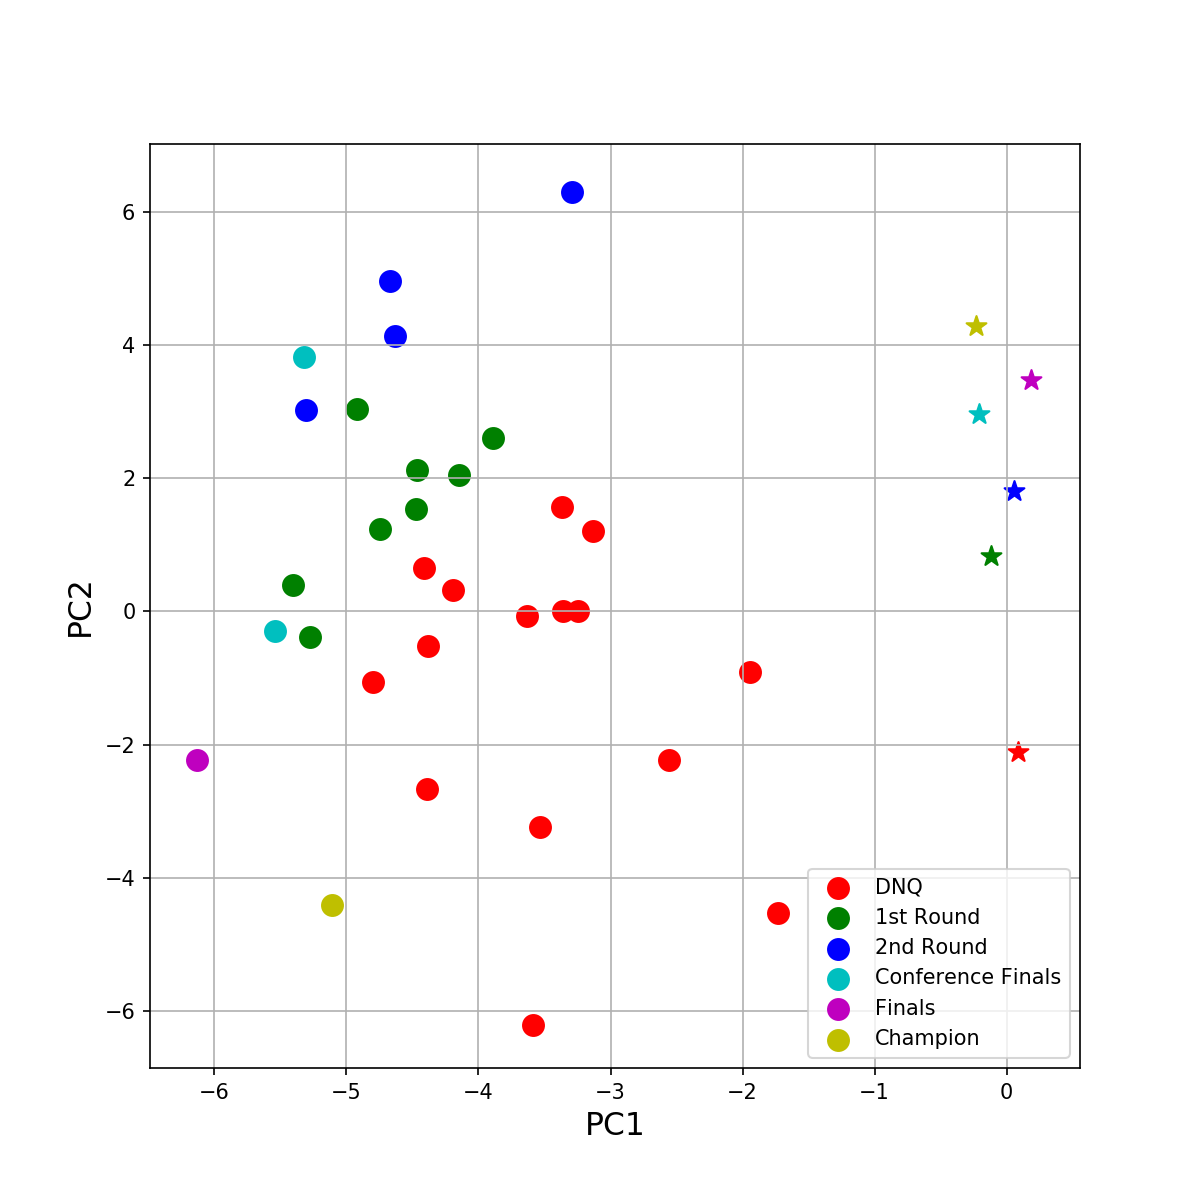

In [232]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
target_labels = ['DNQ', '1st Round', '2nd Round', 'Conference Finals', 'Finals', 'Champion']
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(target_labels,colors):
    indicesToKeep = predictions['better'] == target
    ax.scatter(predictions.loc[indicesToKeep, 'pc1'] ,predictions.loc[indicesToKeep, 'pc2'], c = color ,s = 100)
for target, color in zip(centroid_labels,colors):
    indicesToKeep = predictions['better'] == target
    ax.scatter(predictions.loc[indicesToKeep, 'pc1'] ,predictions.loc[indicesToKeep, 'pc2'], c = color , marker = '*', s = 100)
ax.legend(target_labels)
ax.grid()

### Picking Champion label first and DNQ label last

In [205]:
for p in range(1996, 2018):
    predictions = twoD[(twoD.Year == p)].reset_index(drop = True)
    cluster_size = [14,8,4,2,1,1]
    rev = [1,1,2,4,8,14]
    i=0
    j = 1
    center_list = []
    predictions['cluster'] = ''
    reverse = ['Champion', 'Finals', 'Conference Finals', '2nd Round', '1st Round', 'DNQ']
    for s in reverse:
        x = twoD[twoD.Year != p][(twoD.Playoffs == s)]['pc1'].mean()
        y = twoD[twoD.Year != p][(twoD.Playoffs == s)]['pc2'].mean()
        clus = s + '_cluster'
        predictions.loc[30 + j] = [x, y, clus, 3000, clus]  # adding a row
        j = j + 1
        index = predictions.index + 1  # shifting index
        predictions = predictions.sort_index()
#     z = finalDf[(finalDf.Playoffs == s)]['pc3'].mean()
        center = [[x,y]]
        center_list.append(center)
        copy = predictions
#     c = list(zip(copy['pc1'],copy['pc2'],copy['pc3']))
        c = list(zip(copy['pc1'],copy['pc2']))
        lst = distance.cdist(np.array(c), center, 'euclidean').flatten()
        count = 0
        while count < rev[i]:
            if (predictions.iloc[np.argmin(lst), 4] == ''):
                predictions.iloc[np.argmin(lst),4] = s
                count = count + 1
                lst[np.argmin(lst)] = 1000
            else:
                lst[np.argmin(lst)] = 1000
        i = i + 1
    predictions.loc[predictions.cluster == '', 'cluster'] = "DNQ"
    champ = predictions[predictions['Playoffs']=='Champion'].index.item()
    print('The actual Champion was predicted: ', predictions.loc[champ, "cluster"])
    print('Year: ', p, " ", predictions['Playoffs'].eq(predictions['cluster'].values).mean())

The actual Champion was predicted:  DNQ
Year:  1996   0.4444444444444444
The actual Champion was predicted:  DNQ
Year:  1997   0.4444444444444444
The actual Champion was predicted:  2nd Round
Year:  1998   0.5833333333333334
The actual Champion was predicted:  Conference Finals
Year:  1999   0.5
The actual Champion was predicted:  Champion
Year:  2000   0.5
The actual Champion was predicted:  Champion
Year:  2001   0.5555555555555556
The actual Champion was predicted:  Conference Finals
Year:  2002   0.5277777777777778
The actual Champion was predicted:  DNQ
Year:  2003   0.6111111111111112
The actual Champion was predicted:  1st Round
Year:  2004   0.3888888888888889
The actual Champion was predicted:  DNQ
Year:  2005   0.40540540540540543
The actual Champion was predicted:  DNQ
Year:  2006   0.43243243243243246
The actual Champion was predicted:  DNQ
Year:  2007   0.3783783783783784
The actual Champion was predicted:  DNQ
Year:  2008   0.3783783783783784
The actual Champion was predi

### Accuracy

In [241]:
score = predictions.iloc[:-6]
score['Playoffs'].eq(score['better'].values).mean()

0.4838709677419355

<IPython.core.display.Javascript object>


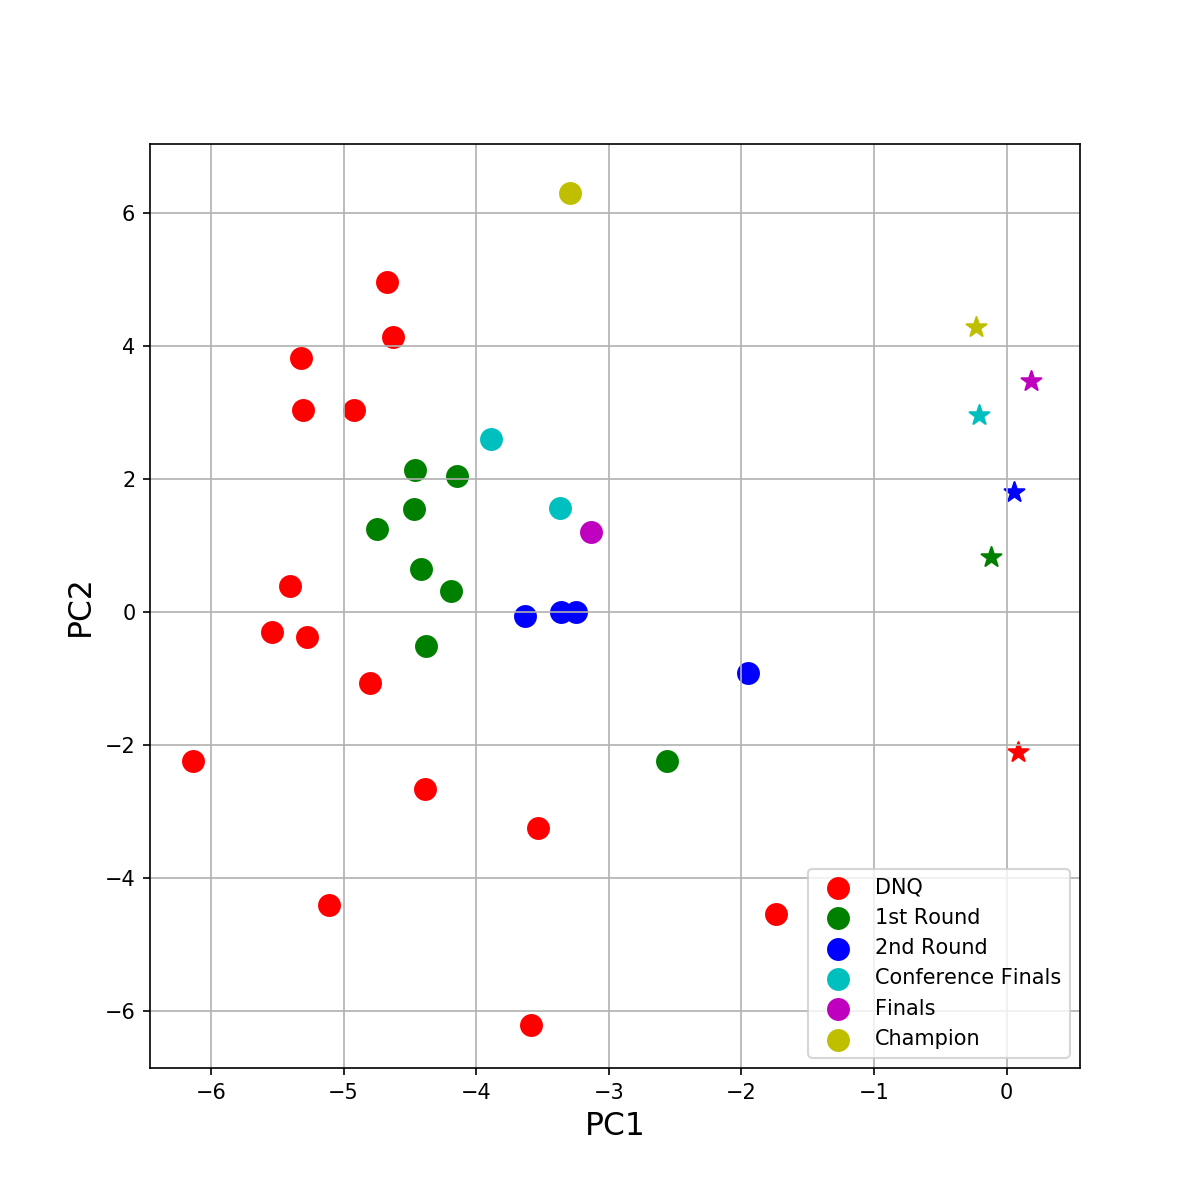

In [242]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
target_labels = ['DNQ', '1st Round', '2nd Round', 'Conference Finals', 'Finals', 'Champion']
centroid_labels = ['DNQ_cluster', '1st Round_cluster', '2nd Round_cluster', 'Conference Finals_cluster', 'Finals_cluster', 'Champion_cluster' ]
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(target_labels,colors):
    indicesToKeep = predictions['better'] == target
    ax.scatter(predictions.loc[indicesToKeep, 'pc1'] ,predictions.loc[indicesToKeep, 'pc2'], c = color ,s = 100)
for target, color in zip(centroid_labels,colors):
    indicesToKeep = predictions['better'] == target
    ax.scatter(predictions.loc[indicesToKeep, 'pc1'] ,predictions.loc[indicesToKeep, 'pc2'], c = color , marker = '*', s = 100)
ax.legend(target_labels)
ax.grid()

### Actual Labels

<IPython.core.display.Javascript object>


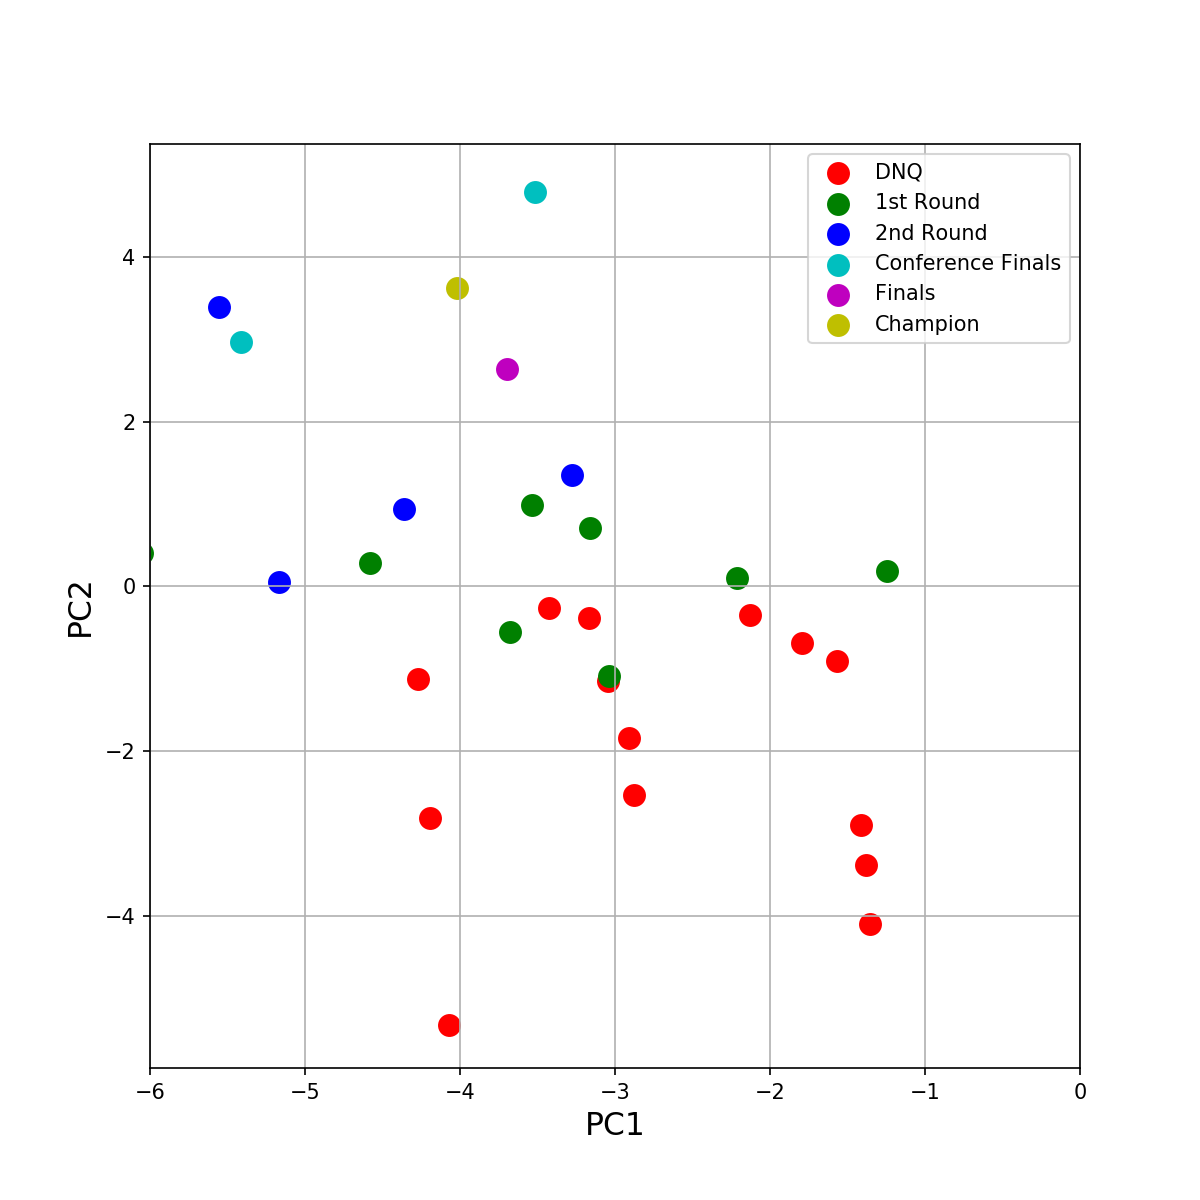

In [246]:
real = finalDf[(finalDf.Year == 2006)]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
colors = ['r', 'g', 'b','c', 'm', 'y']
for target, color in zip(target_labels,colors):
    indicesToKeep = real['Playoffs'] == target
    ax.scatter(real.loc[indicesToKeep, 'pc1'] ,real.loc[indicesToKeep, 'pc2'], c = color ,s = 100)
ax.legend(target_labels)
ax.set_xlim([-6,0])
# ax.set_ylim([-8,8])
# for i, txt in enumerate(real.index):
#     plt.annotate(txt.split()[-1], (finalDf.iloc[:,0][i], finalDf.iloc[:,1][i]))
ax.grid()

# Conclusions
Three different classification models were used: KNN, Random Forest, and a manual Kmeans Cluster. Given that predicting every team as 'DNQ' would yield a ~46% accuracy, all the models scored quite low.

Here are the results from the various models:

* KNN (Standard Data): 56% Mean Accuracy from 5 Fold Cross Validation
* KNN (PCA Data): 55.7% Mean Accuracy from 5 Fold Cross Validation
* Random Forest : 61% Mean Accuracy from 5 Fold Cross Validation
* Manual Kmeans Cluster (DNQ First, Champion Last) : 58% Mean Accuracy from years 1996-2017
* Manual Kmeans Cluster (DNQ Last, Champion First) : 45% Mean Accuracy from years 1996-2017


Here is the success rate of picking the correct champion for each year:

* KNN (Standard Data): 8/38, 21%
* KNN (PCA Data): 2/38, 5%
* Random Forest: 5/38, 13%
* Manual Kmeans Cluster (DNQ First, Champion Last) : 0/22, 0%
* Manual Kmeans Cluster (DNQ Last, Champion First) : 14%



Here is an adjusted succes rate where the correct champion was picked or was labeled "Finals"

* KNN (Standard Data): 11/38, 29%
* KNN (PCA Data): 3/38, 8%
* Random Forest: 12/38, 31.5%
* Manual Kmeans Cluster (DNQ First, Champion Last): 1/22, 4.5%
* Manual Kmeans Cluster (DNQ Last, Champion First) : 3/22, 14%


The Random Forest Classifer outperformed the other models slightly overall, but the KNN (Standard Data) model was the best at predicting the correct Champion. Suprisingly the KNN Classifier trained and predicted on the Standard data performed better than whe used on the PCA data. While the manual Kmeans Cluster (DNQ First) was more accurate than both KNN models overall, it was the worst at predicting the champion. It actually got none correct. The manual Kmeans Cluster (Champion First) performed the worst overall and expectedly performed better at picking the Champion than Kmeans Cluster (DNQ First). However, many of the incorrect labels given by Kmeans Cluster (Champion First) were 'DNQ' which is obviously is the complete other end.
 